# GloVe Classifier

This is a version of the News Classifier that uses GloVe vectors for classification. GloVe vectors were downloaded from [here](https://nlp.stanford.edu/projects/glove/). The vectors are stored in the `data` folder of this repo, which is not commited to source code.

In [149]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch

from time import time

## Load and Setup the Data

In [219]:
start_time = time()

data = pd.read_pickle('./data/train_data_glove.pickle')
labels = pd.read_pickle('./data/train_labels.pickle')
word_embeddings = pd.read_pickle('./data/embeddings.50d.pickle')

end_time = time()

print(f'Ran in {(end_time - start_time)/60:.02f}m.')


Ran in 0.65m.


In [ ]:
# TODO: Clean up __LOW_FREQ_TOKEN

In [224]:
sorted(data.columns, key=lambda word: encoder[word])


KeyError: '__LOW_FREQ_TOKEN__'

In [207]:
word_encoder = {w:i for i,w in enumerate(word_embeddings.index)}
word_decoder = {i:w for w,i in encoder.items()}


In [ ]:
# Re-order columns in data so they match the indices of the
# word encoder. This will make our lives easier later.

data[data.columns]

In [208]:
label_types = {l for l in labels}

label_encoder = {l:i for i, l in enumerate(label_types)}
label_decoder = {i:l for l, i in label_encoder.items()}


In [213]:
data = torch.LongTensor(data.values)
labels = torch.LongTensor([label_encoder[l] for l in labels])
embeddings = torch.FloatTensor(word_embeddings.values)


In [216]:
data.sum(axis=1).shape

torch.Size([64677])

In [217]:
# The data is in bag-of-words format and our model expects a
# sequence of word indices. Need to convert the type here.

def bow_to_sequence(data_bow, encoder):
    """
    Converts a tensor using the bag-of-words data format to two
    tensors: the first tensor is a flat sequence of characters,
    the second tensor is a sequence of offsets to split the data on.
    """
    word_counts = data_bow.sum(axis=1)

    offsets = torch.zeros_like(word_counts, dtype=torch.int64)
    for i, count in enumerate(word_counts[:-1]):
        offsets[i+1] = offsets[i] + count
        
    sequence_len = word_counts.sum()
    sequence = torch.zeros(sequence_len, dtype=torch.int64)
    
    # TODO: Probably a faster way of doing this.
    columns = data_bow.columns
    iter = 0
    for i in range(data_bow.shape[0]):
        for j in range(data_bow.shape[1]):
            for k in range(data_bow[i, j]):
                sequence[iter] = encoder[columns[j]]
                iter += 1
    
    return sequence, offset
    

In [218]:
start_time = time()

data_sequence, data_offset = bow_to_sequence(data, word_encoder)

end_time = time()

print(f'Ran in {(end_time - start_time)/60:.02f}m.')


AttributeError: 'Tensor' object has no attribute 'columns'

## Create the Model

In [104]:
class Model(torch.nn.Module):
    def __init__(self, embeddings, n_classes):
        super(LogisticRegression, self).__init__()

        self.embeddings = torch.nn.EmbeddingBag.from_pretrained(embeddings, mode='sum')
        self.linear = torch.nn.Linear(self.embeddings.embedding_dim, n_classes)
        
    def forward(self, x):
        """
        x is a bag-of-words tensor with dimensions (batch_size, vocab_size).
        """

        outputs = self.linear(x)
        return outputs


In [116]:
model = Model(embeddings=embeddings)
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


## Training the Model

In [119]:
iter = 0
for epoch in range(10000):
    optimizer.zero_grad()
    outputs = model(data)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    
    iter += 1
    
    if iter % 1000 == 0:
        predictions = (outputs[:, 0] < outputs[:, 1]).type(torch.LongTensor)
        correct = (predictions == labels).sum()
        total = labels.shape[0]
        print(f'Accuracy: {float(correct) / total:.02f}')


Accuracy: 0.65
Accuracy: 0.65
Accuracy: 0.65
Accuracy: 0.65
Accuracy: 0.65
Accuracy: 0.65
Accuracy: 0.65
Accuracy: 0.65
Accuracy: 0.65
Accuracy: 0.65


## Check Results

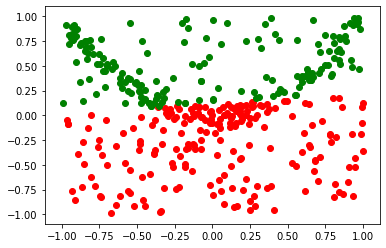

In [122]:
with torch.no_grad():
    outputs = model(data)
    predictions = (outputs[:, 0] < outputs[:, 1]).type(torch.LongTensor)
    
    data_0 = data[predictions == 0, :]
    data_1 = data[predictions == 1, :]

    plt.scatter(data_0[:, 0], data_0[:, 1], c='r')
    plt.scatter(data_1[:, 0], data_1[:, 1], c='g')
    plt.show()
    